### Loading and prerequesites

In [1]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [2]:
VARIANT = "FULL" # "SMALL", "MEDIUM" , "FULL"

if VARIANT == "SMALL":
    df = pd.read_pickle("../Data/df.pkl")
    df = df.head(30)
elif VARIANT == "MEDIUM":
    df = pd.read_pickle("../Data/df.pkl")
    df = df.head(500)
else:
    df = pd.read_pickle("../Data/df.pkl")

### General overview over the dataset

In [3]:
df

,nexis_id,title,publication_date,publication_year,publisher,text
0,5MNMH621JB0GF09H0000000,Angst vor dem «harten Brexit» auf der Insel - ...,2017-01-15,2017,AP Deutsch,Wenn Großbritannien Ende März den Ausstieg aus...
1,5SM3THB1DXFJ50MP0000000,Fleischindustrie wehrt sich gegen Marketing fü...,2018-06-21,2018,AP Deutsch,Fleisch aus dem Labor ist noch eine Zukunftsvi...
2,5SM3THB1DXFJ50MY0000000,Der AP-Überblick am Nachmittag,2018-06-21,2018,AP Deutsch,Die AP Weltnachrichten haben heute unter ander...
3,5STNVWH1DXFJ53VM0000000,Laborfleisch soll in drei Jahren auf die Telle...,2018-07-17,2018,AP Deutsch,Maastricht (AP) - Das niederländische Unterneh...
4,5VHK2XG1JB0GF4Y50000000,Israelische Forscher wollen künstliche Steaks ...,2019-02-26,2019,AP Deutsch,"Die Weltbevölkerung wächst, die Nachfrage nach..."
...,...,...,...,...,...,...
5280,67KW1VK1F15WB4660000000,Kein Titel,2023-02-21,2023,ZEIT Wissen,6 Am anfang drei Fragen 1. Können wir andere m...
5281,67KW1VK1F15WB46B0000000,Leben und schmecken lassen,2023-02-21,2023,ZEIT Wissen,"Ein saftiges Filet, für das kein Huhn sterben ..."
5282,7W29GN20YC2460S30000000,ABSCHIED VOM ALTEN ITALIEN,2009-05-13,2009,ZEIT Wissen,John Dickie: »Delizia! Die Italiener und ihre...
5283,7X8DW4712SK2G0H10000000,Essen aus dem Labor,2009-12-08,2009,ZEIT Wissen,Es ist der letzte Tag auf der Lebensmittelmess...


In [4]:
print("First Textual Overview of the Dataset:")
print("------------------------")
print("First Publication Year:", df['publication_date'].min().year)
print("Last Publication Year:", df['publication_date'].max().year)
print("Total Number of Publications:", len(df))
print("\nNumber of Publications per Year:")
print(df['publication_year'].value_counts().sort_index())
print("\nNumber of Publications per Publisher:")
print(df['publisher'].value_counts())

First Textual Overview of the Dataset:
------------------------
First Publication Year: 1992
Last Publication Year: 2023
Total Number of Publications: 5285

Number of Publications per Year:
publication_year
1992      3
1993      6
1994     18
1995     20
1996     29
1997     49
1998     60
1999     97
2000    100
2001     64
2002     62
2003    151
2004    322
2005    191
2006    145
2007    127
2008    154
2009    137
2010     95
2011    104
2012    126
2013    154
2014    239
2015    201
2016    224
2017    136
2018    282
2019    256
2020    210
2021    348
2022    352
2023    823
Name: count, dtype: int64

Number of Publications per Publisher:
publisher
taz, die tageszeitung        428
Lebensmittel Zeitung         371
Stuttgarter Zeitung          179
Frankfurter Rundschau        179
dpa-AFX ProFeed              164
                            ... 
Blick am Abend                 1
BILD Sachsen-Anhalt            1
Mlr Baden Wuerttemberg.de      1
BILD Frankfurt                 1
Logi

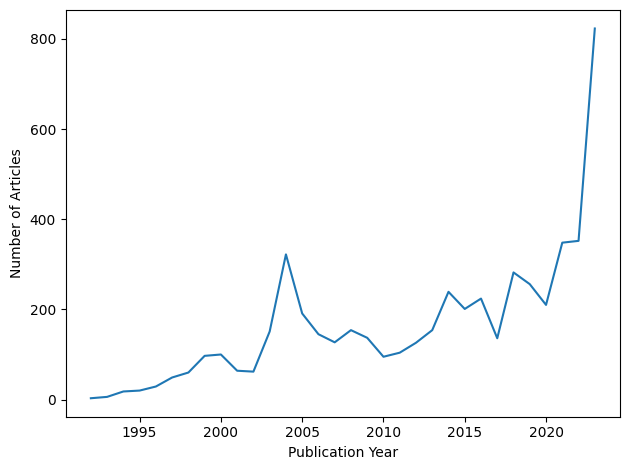

In [5]:
df['publication_year'].value_counts().sort_index().plot(legend = None)
plt.xlabel('Publication Year')
plt.ylabel('Number of Articles')
plt.savefig('../Visuals/articles_per_year_graph.png')
plt.show()

                            OLS Regression Results                            
Dep. Variable:          article_count   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     57.73
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           1.79e-08
Time:                        17:32:35   Log-Likelihood:                -185.28
No. Observations:                  32   AIC:                             374.6
Df Residuals:                      30   BIC:                             377.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2.372e+04   3140.891  

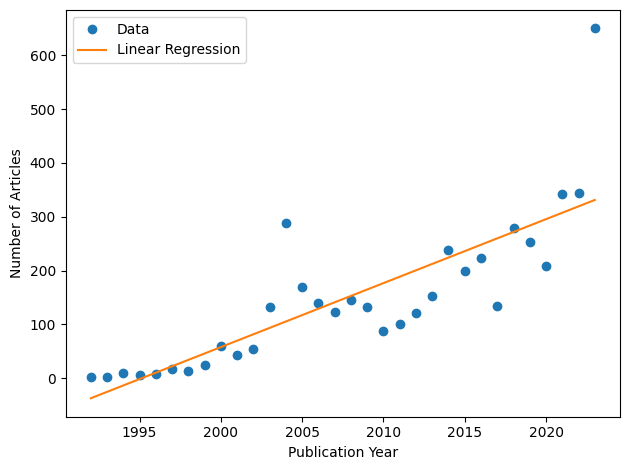

In [6]:
# Overview over yearly publications
# Calculate the number of articles published per year and add it as a column to a new dataframe
df_year = df.groupby('publication_year').count()
df_year = df_year[['title']]
df_year.columns = ['article_count']
df_year = df_year.reset_index()

# Fit a linear regression curve to the data
X = sm.add_constant(df_year['publication_year'])
y = df_year['article_count']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

# Print the confidence intervals for the coefficients
conf_int = results.conf_int()
print("\nConfidence Intervals for the Coefficients:")
print(conf_int)

# Plot the data points and the linear regression curve
plt.plot(df_year['publication_year'], y, 'o', label='Data')
plt.plot(df_year['publication_year'], results.predict(X), label='Linear Regression')
plt.xlabel('Publication Year')
plt.ylabel('Number of Articles')
plt.legend()
plt.savefig('../Visuals/articles_per_year.png')
plt.show()

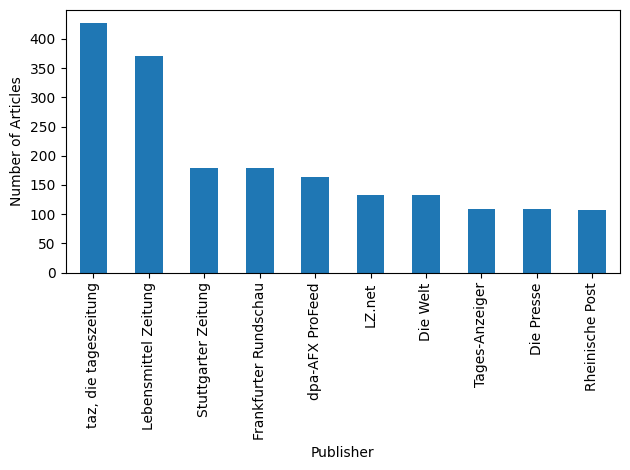

In [7]:
# Overview over publishers with most publications
df['publisher'].value_counts().nlargest(10).plot(legend = None, kind='bar',)
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.savefig('../Visuals/top_10_publishers.png')
plt.show()

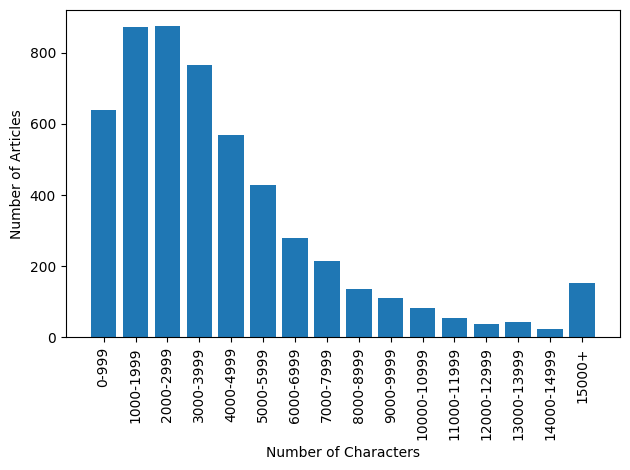

In [8]:
# Overview over articles length
# Define the intervals
intervals = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, float('inf')]

# Group the articles based on length intervals
grouped_articles = df.groupby(pd.cut(df['text'].str.len(), intervals)).size()

# Plot the bar plot
plt.bar(range(len(grouped_articles)), grouped_articles)

# Set the x-axis labels
plt.xticks(range(len(grouped_articles)), [f'{int(x.left)}-{int(x.right-1)}' if x.right != float('inf') else f'{int(x.left)}+' for x in grouped_articles.index], rotation=90)

# Set the x-axis label
plt.xlabel('Number of Characters')

# Set the y-axis label
plt.ylabel('Number of Articles')

# Save the plot
plt.savefig('../Visuals/articles_grouped_by_length.png')

# Show the plot
plt.show()

                            OLS Regression Results                            
Dep. Variable:        avg_text_length   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     15.97
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           0.000385
Time:                        17:32:36   Log-Likelihood:                -256.79
No. Observations:                  32   AIC:                             517.6
Df Residuals:                      30   BIC:                             520.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.131e+05   2.94e+04  

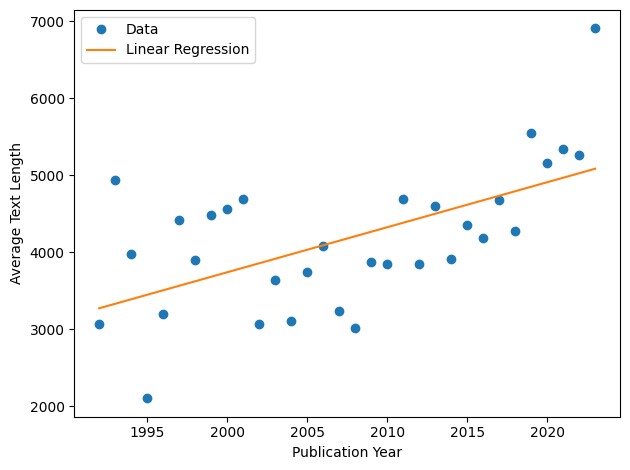

In [9]:
# Calculate the average length of text for each publication year
df_grouped = df.groupby('publication_year')['text'].apply(lambda x: x.str.len().mean()).reset_index()

# Rename the colum text to avg_text_length in the new dataframe
df_grouped.rename(columns={'text': 'avg_text_length'}, inplace=True)

# Fit a linear regression curve to the data
X = sm.add_constant(df_grouped['publication_year'])
y = df_grouped['avg_text_length']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

# Print the confidence intervals for the coefficients
conf_int = results.conf_int()
print("\nConfidence Intervals for the Coefficients:")
print(conf_int)

# Plot the data points and the linear regression curve
plt.plot(df_grouped['publication_year'], y, 'o', label='Data')
plt.plot(df_grouped['publication_year'], results.predict(X), label='Linear Regression')
plt.xlabel('Publication Year')
plt.ylabel('Average Text Length')
plt.legend()
plt.savefig('../Visuals/yearly_text_length.png')
plt.show()

### Frequent words

In [10]:
# Use small spacy model
nlp = spacy.load("de_core_news_sm")

# Add a column with the spacy doc object for each article
df['spacy_doc'] = df['text'].apply(nlp)

spacy_doc
Prozent         11286
Lebensmittel     7469
Fleisch          7075
Produkt          6267
Unternehmen      5736
gentechnisch     5380
Mensch           5022
Deutschland      4384
deutsch          4142
stehen           4014
verändert        4000
USA              3969
Gentechnik       3862
sehen            3773
Pflanze          3575
Tier             3384
Verbraucher      3316
Markt            3132
Euro             2979
EU               2895
Name: count, dtype: int64


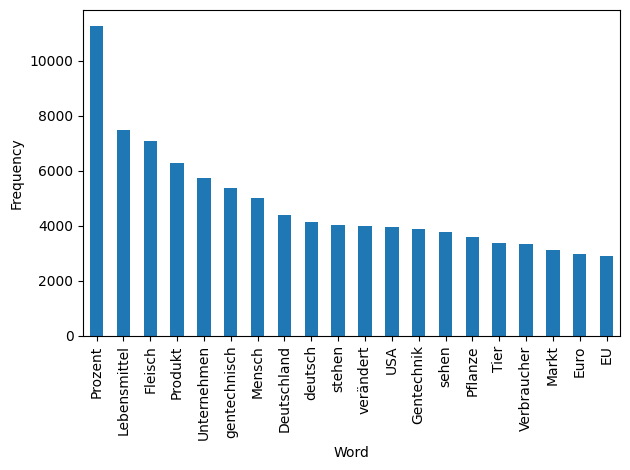

In [11]:
# Find the most frequent words in df and their frequencies
word_freq = df['spacy_doc'].apply(lambda x: [token.lemma_ for token in x if not token.is_stop and not token.is_punct and not token.is_digit]).explode().value_counts()
#word_freq = df['spacy_doc'].apply(lambda x: [token.lemma_ for token in x]).explode().value_counts()

# Remove whitespace-only strings
word_freq = word_freq[word_freq.index.str.strip() != '']

# Remove double lines
word_freq = word_freq[word_freq.index.str.strip() != '--']

# Workaround: Remove all texts where the words "and", "the", "to" and "of" appear more than twice.
# No longer needed since all non-german articles have been removed
#word_freq = word_freq[(word_freq.index != 'and') & (word_freq.index != 'the') & (word_freq.index != 'The') & (word_freq.index != 'to') & (word_freq.index != 'of')]
#word_freq = word_freq[word_freq > 2]

# Print the most frequent words as text
print(word_freq.nlargest(20))

# Plot the 20 most frequent words
word_freq.nlargest(20).plot(kind='bar')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.savefig('../Visuals/top_20_words.png')
plt.show()

In [12]:
# Find the texts with the most occurences of "Prozent"
df['prozent_count'] = df['spacy_doc'].apply(lambda x: sum([1 for token in x if token.lemma_ == 'Prozent']))
df['prozent_count'].nlargest(10)

# Print the texts with the most occurences of "Prozent", the frequency of the word "Prozent" and the publisher of the article
for i in df['prozent_count'].nlargest(10).index:
    print(df.loc[i]['publisher'])
    print(df.loc[i]['text'])
    print(df.loc[i]['prozent_count'])
    print('------------------------')

print()

print(str(sum(df['prozent_count'] > 5)) + ' Artikel mit mehr als 5 Vorkommen von Prozent')
print(str(sum(df['prozent_count'] > 50)) + ' Artikel mit mehr als 50 Vorkommen von Prozent')


Bayerischer Rundfunk
22.00 Uhr - Wall Street schließt mit kräftigen Gewinnen Die US-Börsen können nach einer eher zähen Woche zum Ende kräftige Gewinne verbuchen: Der Dow Jones ist fast ein Prozent fester aus dem Handel gegangen, der Nasdaq konnte um anderthalb Prozent zulegen... 22.00 Uhr - Wall Street schließt mit kräftigen Gewinnen  Die US-Börsen können nach einer eher zähen Woche zum Ende kräftige Gewinne verbuchen: Der Dow Jones ist fast ein Prozent fester aus dem Handel gegangen, der Nasdaq konnte um anderthalb Prozent zulegen. Positiv kamen bei Anlegern unter anderem die stagnierenden US-Konsumausgaben im Mai an. Gefragt waren außerdem Tech-Werte und Banken-Titel. Apple hat erstmals in der Geschichte zu Börsenschluss einen Wert von mehr als drei Billionen Dollar.  21.09 Uhr - US-Banken an der Wall Street gefragt  In den USA greifen Anlegerinnen und Anleger bei den Aktien von Banken zu: JP Morgan, Bank of America, Wells Fargo und Morgan Stanley gewinnen bis zu 1,7 Prozent. Dies s

### Questions

In [13]:
def count_questions(text):
    return sum(1 for sent in text.sents if sent.text.strip().endswith('?'))

In [14]:
df['questions_count'] = df["spacy_doc"].apply(count_questions)

In [15]:
# Add a column with the number of characters in the text
df['characters_count'] = df['text'].str.len()

# Add a column with the ratio of questions to characters
df['questions_ratio'] = df['questions_count'] / df['characters_count']

In [16]:
df
df_sorted = df.sort_values(by='questions_ratio', ascending=False)
df_sorted

,nexis_id,title,publication_date,publication_year,publisher,text,spacy_doc,prozent_count,questions_count,characters_count,questions_ratio
4199,67DH39P1JC8114CH0000000,"Vegan, aber ?Fleischerei??",2023-01-27,2023,Sächsische Zeitung Regionalausgaben,Schnitzel- und Fleischkäsebrötchen auf die Han...,"(Schnitzel-, und, Fleischkäsebrötchen, auf, di...",0,41,4195,0.009774
722,5S2T9DY1JCTWB3T40000000,1 Essen nach maß 30 31 38 41,2018-04-11,2018,Der Standard,19 24 Mythen im Faktencheck Was bringen Detox-...,"(19, 24, Mythen, im, Faktencheck, Was, bringen...",0,1,108,0.009259
438,5WWBF9D1F07YK01F0000000,FOOD-NEWS,2019-08-22,2019,Bunte,Wurst- und Fleisch-alternativen EVENTLOCATION ...,"(Wurst-, und, Fleisch-alternativen, EVENTLOCAT...",0,1,108,0.009259
853,7XMCMWY12RKCK2JP0000000,Der Mai ist nicht gekommen Von Harald Martenstein,2010-01-24,2010,Der Tagesspiegel,Im Mai wird die Sonne scheinen - ganz bestimmt...,"(Im, Mai, wird, die, Sonne, scheinen, -, ganz,...",0,20,2371,0.008435
5277,5NV18G31F15WB0890000000,FORSCHUNG & TECHNIK,2017-06-20,2017,ZEIT Wissen,"Tanker, Frachter, Piraten: Auf dem Meer ist wa...","(Tanker, ,, Frachter, ,, Piraten, :, Auf, dem,...",0,14,1918,0.007299
...,...,...,...,...,...,...,...,...,...,...,...
2948,5G7G7JP1DYJRP1720000000,Jury nominiert neun Projekte für Bestform,2015-06-17,2015,Mitteldeutsche Zeitung,HALLE/MZ/JDS - Die Jury der von der landeseige...,"(HALLE, /, MZ, /, JDS, -, Die, Jury, der, von,...",0,0,1846,0.000000
2951,5HKW56H1JC3P00400000000,Ein Hase aus Würmern,2015-12-14,2015,Mitteldeutsche Zeitung,Aufgeschnappt von Katja Pausch VON NICOLAS OTT...,"(Aufgeschnappt, von, Katja, Pausch, VON, NICOL...",0,0,4183,0.000000
1294,64HSHSM1JDPTM46F0000000,Amerika diktiert nichts!,2014-05-08,2014,Die ZEIT (inklusive ZEIT Magazin),*** TTIPTTIP ist die englische Abkürzung für d...,"(*, *, *, TTIPTTIP, ist, die, englische, Abkür...",0,0,544,0.000000
1293,64HSHSM1JDPTM41Y0000000,Endlich wieder dick!,2014-04-30,2014,Die ZEIT (inklusive ZEIT Magazin),Als Boris Becker sich zuletzt im Fernsehen zei...,"(Als, Boris, Becker, sich, zuletzt, im, Fernse...",0,0,875,0.000000


                            OLS Regression Results                            
Dep. Variable:        questions_ratio   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     29.37
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           7.14e-06
Time:                        17:37:17   Log-Likelihood:                -20.289
No. Observations:                  32   AIC:                             44.58
Df Residuals:                      30   BIC:                             47.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -96.6015     18.108  

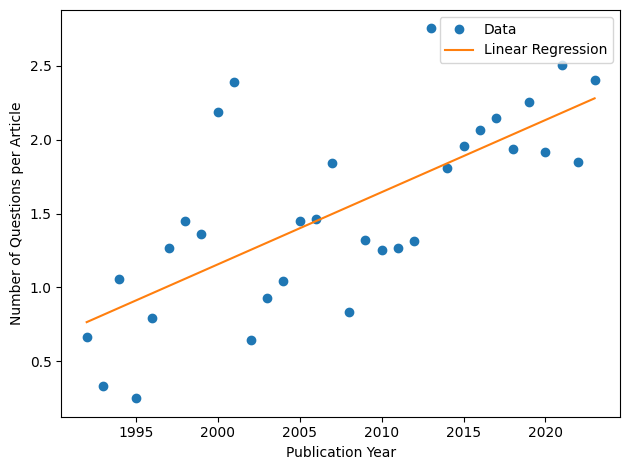

In [17]:
# Visualize the number of questions per article per year and fit a linear regression curve to the data
# Group by year and calculate the total number of questions and total number of articles for each year
df_grouped = df.groupby('publication_year').agg({'questions_count': 'sum', 'text': 'count'})

# Calculate the ratio of questions to total articles for each year
df_grouped['questions_ratio'] = df_grouped['questions_count'] / df_grouped['text']

# Make the index a column
df_grouped.reset_index(inplace=True)

# Fit a linear regression curve to the data
X = sm.add_constant(df_grouped['publication_year'])
y = df_grouped['questions_ratio']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

# Print the confidence intervals for the coefficients
conf_int = results.conf_int()
print("\nConfidence Intervals for the Coefficients:")
print(conf_int)

# Plot the data points and the linear regression curve
plt.plot(df_grouped['publication_year'], y, 'o', label='Data')
plt.plot(df_grouped['publication_year'], results.predict(X), label='Linear Regression')
plt.xlabel('Publication Year')
plt.ylabel('Number of Questions per Article')
plt.legend()
plt.savefig('../Visuals/questions_ratio_per_text.png')
plt.show()

                            OLS Regression Results                            
Dep. Variable:        questions_ratio   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     13.38
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           0.000969
Time:                        17:37:18   Log-Likelihood:                 249.66
No. Observations:                  32   AIC:                            -495.3
Df Residuals:                      30   BIC:                            -492.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0140      0.004  

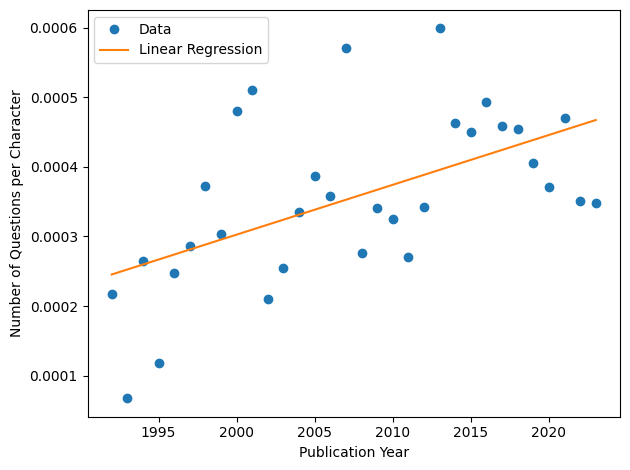

In [18]:
# Visualize the ratio of questions to characters per year and fit a linear regression curve to the data
# Group by year and calculate the total number of questions and total number of characters for each year
df_grouped = df.groupby('publication_year').agg({'questions_count': 'sum', 'characters_count': 'sum'})

# Calculate the ratio of questions to total characters for each year
df_grouped['questions_ratio'] = df_grouped['questions_count'] / df_grouped['characters_count']

# Make the index a column
df_grouped.reset_index(inplace=True)

# Fit a linear regression curve to the data
X = sm.add_constant(df_grouped['publication_year'])
y = df_grouped['questions_ratio']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

# Print the confidence intervals for the coefficients
conf_int = results.conf_int()
print("\nConfidence Intervals for the Coefficients:")
print(conf_int)

# Plot the data points and the linear regression curve
plt.plot(df_grouped['publication_year'], y, 'o', label='Data')
plt.plot(df_grouped['publication_year'], results.predict(X), label='Linear Regression')
plt.xlabel('Publication Year')
plt.ylabel('Number of Questions per Character')
plt.legend()
plt.savefig('../Visuals/questions_ratio_per_character.png')
plt.show()

### Pronouns with spacy

In [19]:
df = pd.read_pickle("../Data/df_full.pkl")

# Use small spacy model
nlp = spacy.load('de_core_news_sm')

df

,nexis_id,title,publication_date,publication_year,publisher,text,clean_text,word_count
0,5MNMH621JB0GF09H0000000,Angst vor dem «harten Brexit» auf der Insel - ...,2017-01-15,2017,AP Deutsch,Wenn Großbritannien Ende März den Ausstieg aus...,wenn großbritannien ende märz der ausstieg aus...,763
1,5SM3THB1DXFJ50MP0000000,Fleischindustrie wehrt sich gegen Marketing fü...,2018-06-21,2018,AP Deutsch,Fleisch aus dem Labor ist noch eine Zukunftsvi...,fleisch aus der labor sein noch ein zukunftsvi...,708
2,5SM3THB1DXFJ50MY0000000,Der AP-Überblick am Nachmittag,2018-06-21,2018,AP Deutsch,Die AP Weltnachrichten haben heute unter ander...,der ap weltnachrichten haben heute unter ander...,632
3,5STNVWH1DXFJ53VM0000000,Laborfleisch soll in drei Jahren auf die Telle...,2018-07-17,2018,AP Deutsch,Maastricht (AP) - Das niederländische Unterneh...,maastricht ap der niederländisch unternehmen...,225
4,5VHK2XG1JB0GF4Y50000000,Israelische Forscher wollen künstliche Steaks ...,2019-02-26,2019,AP Deutsch,"Die Weltbevölkerung wächst, die Nachfrage nach...",der weltbevölkerung wachsen der nachfrage nach...,631
...,...,...,...,...,...,...,...,...
5280,67KW1VK1F15WB4660000000,Kein Titel,2023-02-21,2023,ZEIT Wissen,6 Am anfang drei Fragen 1. Können wir andere m...,6 an anfang drei frage 1 können wir anderer mi...,305
5281,67KW1VK1F15WB46B0000000,Leben und schmecken lassen,2023-02-21,2023,ZEIT Wissen,"Ein saftiges Filet, für das kein Huhn sterben ...",ein saftig filet für der kein huhn sterben mus...,266
5282,7W29GN20YC2460S30000000,ABSCHIED VOM ALTEN ITALIEN,2009-05-13,2009,ZEIT Wissen,John Dickie: »Delizia! Die Italiener und ihre...,john dickie delizia der italiener und ihr kü...,912
5283,7X8DW4712SK2G0H10000000,Essen aus dem Labor,2009-12-08,2009,ZEIT Wissen,Es ist der letzte Tag auf der Lebensmittelmess...,es sein der letzter tag auf der lebensmittelme...,2548


In [20]:
# Add four new columns to the dataframe called 'word_count', 'du_count', 'ihr_count', 'du_ihr_count'
df['word_count'] = 0
df['du_count'] = 0
df['ihr_count'] = 0
df['du_ihr_count'] = 0

# Add three new columns to the dataframe called 'has_du', 'has_ihr' and 'has_du_ihr'
df['has_du'] = False
df['has_ihr'] = False
df['has_du_ihr'] = False

# Define the variants of 'Du' and 'Ihr'
du_variants = ['du', 'dich', 'dein', 'deine', 'deines', 'deiner', 'dir']
ihr_variants = ['ihr', 'euch', 'euer', 'eure', 'eures', 'eurer', 'eur']

# Iterate over the dataframe and count the number of words, 'Du', 'Ihr' and 'Du' and 'Ihr' in each text
for index in df.index:
    doc = nlp(df['clean_text'][index])
    df.loc[index, 'word_count'] = len(doc)
    df.loc[index, 'du_count'] = sum([1 for token in doc if token.text in du_variants])
    df.loc[index, 'ihr_count'] = sum([1 for token in doc if token.text in ihr_variants])
    df.loc[index, 'du_ihr_count'] = df.loc[index, 'du_count'] + df.loc[index, 'ihr_count']

    # Fill the columns 'has_du', 'has_ihr' and 'has_du_ihr' with True if the text contains 'Du', 'Ihr' or 'Du' and 'Ihr'
    if df.loc[index, 'du_count'] > 0:
        df.loc[index, 'has_du'] = True
    if df.loc[index, 'ihr_count'] > 0:
        df.loc[index, 'has_ihr'] = True
    if df.loc[index, 'du_ihr_count'] > 0:
        df.loc[index, 'has_du_ihr'] = True

df

,nexis_id,title,publication_date,publication_year,publisher,text,clean_text,word_count,du_count,ihr_count,du_ihr_count,has_du,has_ihr,has_du_ihr
0,5MNMH621JB0GF09H0000000,Angst vor dem «harten Brexit» auf der Insel - ...,2017-01-15,2017,AP Deutsch,Wenn Großbritannien Ende März den Ausstieg aus...,wenn großbritannien ende märz der ausstieg aus...,763,0,5,5,False,True,True
1,5SM3THB1DXFJ50MP0000000,Fleischindustrie wehrt sich gegen Marketing fü...,2018-06-21,2018,AP Deutsch,Fleisch aus dem Labor ist noch eine Zukunftsvi...,fleisch aus der labor sein noch ein zukunftsvi...,708,0,1,1,False,True,True
2,5SM3THB1DXFJ50MY0000000,Der AP-Überblick am Nachmittag,2018-06-21,2018,AP Deutsch,Die AP Weltnachrichten haben heute unter ander...,der ap weltnachrichten haben heute unter ander...,632,0,4,4,False,True,True
3,5STNVWH1DXFJ53VM0000000,Laborfleisch soll in drei Jahren auf die Telle...,2018-07-17,2018,AP Deutsch,Maastricht (AP) - Das niederländische Unterneh...,maastricht ap der niederländisch unternehmen...,225,0,0,0,False,False,False
4,5VHK2XG1JB0GF4Y50000000,Israelische Forscher wollen künstliche Steaks ...,2019-02-26,2019,AP Deutsch,"Die Weltbevölkerung wächst, die Nachfrage nach...",der weltbevölkerung wachsen der nachfrage nach...,631,0,0,0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5280,67KW1VK1F15WB4660000000,Kein Titel,2023-02-21,2023,ZEIT Wissen,6 Am anfang drei Fragen 1. Können wir andere m...,6 an anfang drei frage 1 können wir anderer mi...,305,1,1,2,True,True,True
5281,67KW1VK1F15WB46B0000000,Leben und schmecken lassen,2023-02-21,2023,ZEIT Wissen,"Ein saftiges Filet, für das kein Huhn sterben ...",ein saftig filet für der kein huhn sterben mus...,266,0,0,0,False,False,False
5282,7W29GN20YC2460S30000000,ABSCHIED VOM ALTEN ITALIEN,2009-05-13,2009,ZEIT Wissen,John Dickie: »Delizia! Die Italiener und ihre...,john dickie delizia der italiener und ihr kü...,912,0,6,6,False,True,True
5283,7X8DW4712SK2G0H10000000,Essen aus dem Labor,2009-12-08,2009,ZEIT Wissen,Es ist der letzte Tag auf der Lebensmittelmess...,es sein der letzter tag auf der lebensmittelme...,2548,0,12,12,False,True,True


In [21]:
df_yearly_overview = pd.DataFrame(columns=['publication_year', 'publication_count', 'word_count', 'du_count', 'ihr_count', 'du_ihr_count'])

# Fill the dataframe with the data
for index in df.index:
    year = df["publication_year"][index]
    if year not in df_yearly_overview['publication_year'].values:
        df_yearly_overview = pd.concat([df_yearly_overview, pd.DataFrame({'publication_year': year, 'publication_count': 0, 'word_count': 0, 'du_count': 0, 'ihr_count': 0, 'du_ihr_count': 0}, index=[0])])
    df_yearly_overview.loc[df_yearly_overview['publication_year'] == year, 'publication_count'] += 1
    df_yearly_overview.loc[df_yearly_overview['publication_year'] == year, 'word_count'] += df["word_count"][index]
    df_yearly_overview.loc[df_yearly_overview['publication_year'] == year, 'du_count'] += df["du_count"][index]
    df_yearly_overview.loc[df_yearly_overview['publication_year'] == year, 'ihr_count'] += df["ihr_count"][index]
    df_yearly_overview.loc[df_yearly_overview['publication_year'] == year, 'du_ihr_count'] += df["du_ihr_count"][index]

# Sort the dataframe by publication_year
df_yearly_overview = df_yearly_overview.sort_values(by='publication_year')

# Reindex the dataframe
df_yearly_overview = df_yearly_overview.reset_index(drop=True)

df_yearly_overview

,publication_year,publication_count,word_count,du_count,ihr_count,du_ihr_count
0,1992,3,1214,0,2,2
1,1993,6,3921,0,12,12
2,1994,18,9408,0,59,59
3,1995,20,5510,2,25,27
4,1996,29,12124,0,27,27
5,1997,49,28409,0,86,86
6,1998,60,31397,18,103,121
7,1999,97,58204,4,220,224
8,2000,100,62409,8,268,276
9,2001,64,40897,14,180,194


In [22]:
# Add newcolumns to the dataframe called 'articles_with_du_count', 'articles_without_du_count', 'articles_with_ihr_count', 'articles_without_ihr_count', 'articles_with_du_ihr_count', 'articles_without_du_ihr_count'
df_yearly_overview['articles_with_du_count'] = 0
df_yearly_overview['articles_without_du_count'] = 0
df_yearly_overview['articles_with_ihr_count'] = 0
df_yearly_overview['articles_without_ihr_count'] = 0
df_yearly_overview['articles_with_du_ihr_count'] = 0
df_yearly_overview['articles_without_du_ihr_count'] = 0

# Iterate over df and count the number of articles with and without 'Du' in each year and fill the data into df_yearly_overview
for index in df.index:
    year = df["publication_year"][index]
    if df["has_du"][index]:
        df_yearly_overview.loc[df_yearly_overview['publication_year'] == year, 'articles_with_du_count'] += 1
    else:
        df_yearly_overview.loc[df_yearly_overview['publication_year'] == year, 'articles_without_du_count'] += 1
    if df["has_ihr"][index]:
        df_yearly_overview.loc[df_yearly_overview['publication_year'] == year, 'articles_with_ihr_count'] += 1
    else:
        df_yearly_overview.loc[df_yearly_overview['publication_year'] == year, 'articles_without_ihr_count'] += 1
    if df["has_du_ihr"][index]:
        df_yearly_overview.loc[df_yearly_overview['publication_year'] == year, 'articles_with_du_ihr_count'] += 1
    else:
        df_yearly_overview.loc[df_yearly_overview['publication_year'] == year, 'articles_without_du_ihr_count'] += 1

# Add new columns to the dataframe df_yearly_overview called 'articles_with_du_ratio', 'articles_with_ihr_ratio', 'articles_with_du_ihr_ratio'
df_yearly_overview['articles_with_du_ratio'] = 0
df_yearly_overview['articles_with_ihr_ratio'] = 0
df_yearly_overview['articles_with_du_ihr_ratio'] = 0

# Calculate the ratios and fill the data into df_yearly_overview
for index in df_yearly_overview.index:
    df_yearly_overview.loc[index, 'articles_with_du_ratio'] = df_yearly_overview.loc[index, 'articles_with_du_count'] / df_yearly_overview.loc[index, 'publication_count']
    df_yearly_overview.loc[index, 'articles_with_ihr_ratio'] = df_yearly_overview.loc[index, 'articles_with_ihr_count'] / df_yearly_overview.loc[index, 'publication_count']
    df_yearly_overview.loc[index, 'articles_with_du_ihr_ratio'] = df_yearly_overview.loc[index, 'articles_with_du_ihr_count'] / df_yearly_overview.loc[index, 'publication_count']

df_yearly_overview

,publication_year,publication_count,word_count,du_count,ihr_count,du_ihr_count,articles_with_du_count,articles_without_du_count,articles_with_ihr_count,articles_without_ihr_count,articles_with_du_ihr_count,articles_without_du_ihr_count,articles_with_du_ratio,articles_with_ihr_ratio,articles_with_du_ihr_ratio
0,1992,3,1214,0,2,2,0,3,2,1,2,1,0.000000,0.666667,0.666667
1,1993,6,3921,0,12,12,0,6,4,2,4,2,0.000000,0.666667,0.666667
2,1994,18,9408,0,59,59,0,18,11,7,11,7,0.000000,0.611111,0.611111
3,1995,20,5510,2,25,27,1,19,10,10,11,9,0.050000,0.500000,0.550000
4,1996,29,12124,0,27,27,0,29,14,15,14,15,0.000000,0.482759,0.482759
5,1997,49,28409,0,86,86,0,49,31,18,31,18,0.000000,0.632653,0.632653
6,1998,60,31397,18,103,121,3,57,36,24,36,24,0.050000,0.600000,0.600000
7,1999,97,58204,4,220,224,4,93,61,36,61,36,0.041237,0.628866,0.628866
8,2000,100,62409,8,268,276,5,95,78,22,78,22,0.050000,0.780000,0.780000
9,2001,64,40897,14,180,194,6,58,38,26,39,25,0.093750,0.593750,0.609375


In [23]:
# Calculate the ratio of count_du to total publications for each year
df_yearly_overview['du_ratio_per_article'] = df_yearly_overview['du_count'] / df_yearly_overview['publication_count']

# Calculate the ratio of count_ihr to total publications for each year
df_yearly_overview['ihr_ratio_per_article'] = df_yearly_overview['ihr_count'] / df_yearly_overview['publication_count']

# Calculate the ratio of count_du_ihr to total publications for each year
df_yearly_overview['du_ihr_ratio_per_article'] = df_yearly_overview['du_ihr_count'] / df_yearly_overview['publication_count']

# Calculate the ratio of count_du to total words for each year
df_yearly_overview['du_ratio_per_word'] = df_yearly_overview['du_count'] / df_yearly_overview['word_count']

# Calculate the ratio of count_ihr to total words for each year
df_yearly_overview['ihr_ratio_per_word'] = df_yearly_overview['ihr_count'] / df_yearly_overview['word_count']

# Calculate the ratio of count_du_ihr to total words for each year
df_yearly_overview['du_ihr_ratio_per_word'] = df_yearly_overview['du_ihr_count'] / df_yearly_overview['word_count']

df_yearly_overview

,publication_year,publication_count,word_count,du_count,ihr_count,du_ihr_count,articles_with_du_count,articles_without_du_count,articles_with_ihr_count,articles_without_ihr_count,...,articles_without_du_ihr_count,articles_with_du_ratio,articles_with_ihr_ratio,articles_with_du_ihr_ratio,du_ratio_per_article,ihr_ratio_per_article,du_ihr_ratio_per_article,du_ratio_per_word,ihr_ratio_per_word,du_ihr_ratio_per_word
0,1992,3,1214,0,2,2,0,3,2,1,...,1,0.000000,0.666667,0.666667,0.0,0.666667,0.666667,0.0,0.001647,0.001647
1,1993,6,3921,0,12,12,0,6,4,2,...,2,0.000000,0.666667,0.666667,0.0,2.0,2.0,0.0,0.00306,0.00306
2,1994,18,9408,0,59,59,0,18,11,7,...,7,0.000000,0.611111,0.611111,0.0,3.277778,3.277778,0.0,0.006271,0.006271
3,1995,20,5510,2,25,27,1,19,10,10,...,9,0.050000,0.500000,0.550000,0.1,1.25,1.35,0.000363,0.004537,0.0049
4,1996,29,12124,0,27,27,0,29,14,15,...,15,0.000000,0.482759,0.482759,0.0,0.931034,0.931034,0.0,0.002227,0.002227
5,1997,49,28409,0,86,86,0,49,31,18,...,18,0.000000,0.632653,0.632653,0.0,1.755102,1.755102,0.0,0.003027,0.003027
6,1998,60,31397,18,103,121,3,57,36,24,...,24,0.050000,0.600000,0.600000,0.3,1.716667,2.016667,0.000573,0.003281,0.003854
7,1999,97,58204,4,220,224,4,93,61,36,...,36,0.041237,0.628866,0.628866,0.041237,2.268041,2.309278,0.000069,0.00378,0.003849
8,2000,100,62409,8,268,276,5,95,78,22,...,22,0.050000,0.780000,0.780000,0.08,2.68,2.76,0.000128,0.004294,0.004422
9,2001,64,40897,14,180,194,6,58,38,26,...,25,0.093750,0.593750,0.609375,0.21875,2.8125,3.03125,0.000342,0.004401,0.004744


### Overview over the usage of 'Du'

                             OLS Regression Results                             
Dep. Variable:     du_ratio_per_article   R-squared:                       0.090
Model:                              OLS   Adj. R-squared:                  0.060
Method:                   Least Squares   F-statistic:                     2.983
Date:                  Mon, 22 Jan 2024   Prob (F-statistic):             0.0944
Time:                          17:41:41   Log-Likelihood:                 36.367
No. Observations:                    32   AIC:                            -68.73
Df Residuals:                        30   BIC:                            -65.80
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               

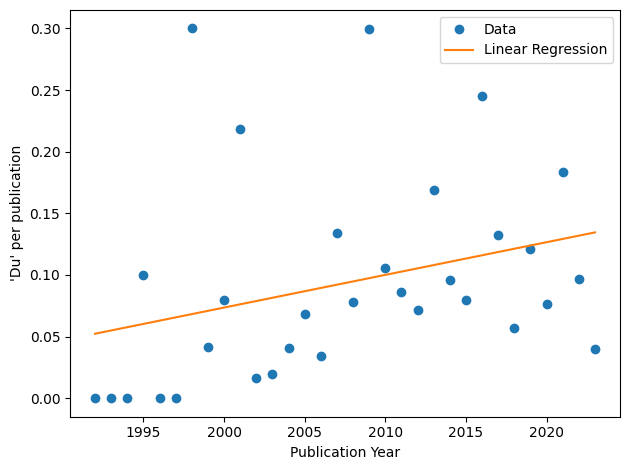

In [24]:
# Visualize the data of 'Du' per publication
# Fit a linear regression curve to the data
X = sm.add_constant(df_yearly_overview['publication_year'])
y = df_yearly_overview['du_ratio_per_article']
model = sm.OLS(y.astype(float), X.astype(float))
results = model.fit()
print(results.summary())

# Print the confidence intervals for the coefficients
conf_int = results.conf_int()
print("\nConfidence Intervals for the Coefficients:")
print(conf_int)

# Plot the data points and the linear regression curve
plt.plot(df_yearly_overview['publication_year'], y, 'o', label='Data')
plt.plot(df_yearly_overview['publication_year'], results.predict(X), label='Linear Regression')
plt.xlabel('Publication Year')
plt.ylabel('\'Du\' per publication')
plt.legend()
plt.savefig('../Visuals/count_du_per_publication.png')
plt.show()

                            OLS Regression Results                            
Dep. Variable:      du_ratio_per_word   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.6827
Date:                Mon, 22 Jan 2024   Prob (F-statistic):              0.415
Time:                        17:41:41   Log-Likelihood:                 236.73
No. Observations:                  32   AIC:                            -469.5
Df Residuals:                      30   BIC:                            -466.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0047      0.006  

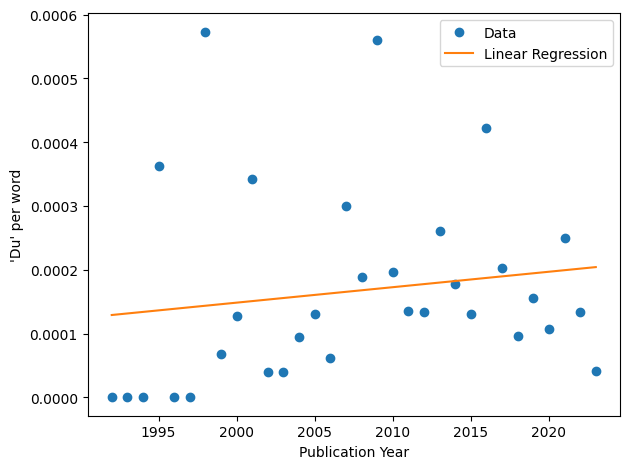

In [25]:
# Visualize the data of 'Du' per word
# Fit a linear regression curve to the data
X = sm.add_constant(df_yearly_overview['publication_year'])
y = df_yearly_overview['du_ratio_per_word']
model = sm.OLS(y.astype(float), X.astype(float))
results = model.fit()
print(results.summary())

# Print the confidence intervals for the coefficients
conf_int = results.conf_int()
print("\nConfidence Intervals for the Coefficients:")
print(conf_int)

# Plot the data points and the linear regression curve
plt.plot(df_yearly_overview['publication_year'], y, 'o', label='Data')
plt.plot(df_yearly_overview['publication_year'], results.predict(X), label='Linear Regression')
plt.xlabel('Publication Year')
plt.ylabel('\'Du\' per word')
plt.legend()
plt.savefig('../Visuals/count_du_per_word.png')
plt.show()

                              OLS Regression Results                              
Dep. Variable:     articles_with_du_ratio   R-squared:                       0.160
Model:                                OLS   Adj. R-squared:                  0.132
Method:                     Least Squares   F-statistic:                     5.715
Date:                    Mon, 22 Jan 2024   Prob (F-statistic):             0.0233
Time:                            17:41:42   Log-Likelihood:                 77.961
No. Observations:                      32   AIC:                            -151.9
Df Residuals:                          30   BIC:                            -149.0
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------


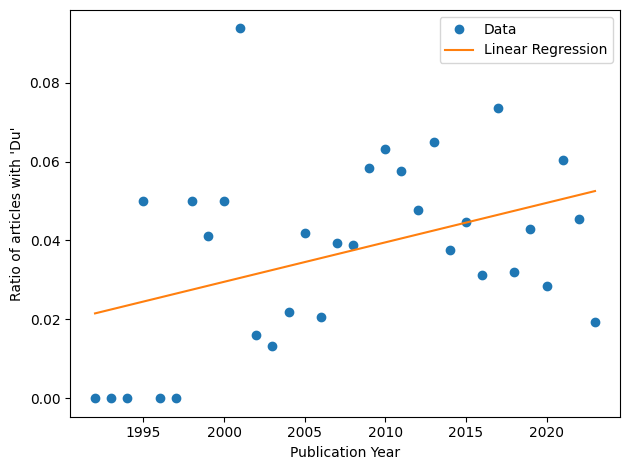

In [26]:
# Visualize the data of articles with 'Du' per publication
# Fit a linear regression curve to the data
X = sm.add_constant(df_yearly_overview['publication_year'])
y = df_yearly_overview['articles_with_du_ratio']
model = sm.OLS(y.astype(float), X.astype(float))
results = model.fit()
print(results.summary())

# Print the confidence intervals for the coefficients
conf_int = results.conf_int()
print("\nConfidence Intervals for the Coefficients:")
print(conf_int)

# Plot the data points and the linear regression curve
plt.plot(df_yearly_overview['publication_year'], y, 'o', label='Data')
plt.plot(df_yearly_overview['publication_year'], results.predict(X), label='Linear Regression')
plt.xlabel('Publication Year')
plt.ylabel('Ratio of articles with \'Du\'')
plt.legend()
plt.savefig('../Visuals/articles_with_du_ratrio.png')
plt.show()

### Overview over the usage of 'Ihr'

                              OLS Regression Results                             
Dep. Variable:     ihr_ratio_per_article   R-squared:                       0.104
Model:                               OLS   Adj. R-squared:                  0.074
Method:                    Least Squares   F-statistic:                     3.477
Date:                   Mon, 22 Jan 2024   Prob (F-statistic):             0.0721
Time:                           17:41:42   Log-Likelihood:                -26.218
No. Observations:                     32   AIC:                             56.44
Df Residuals:                         30   BIC:                             59.37
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const     

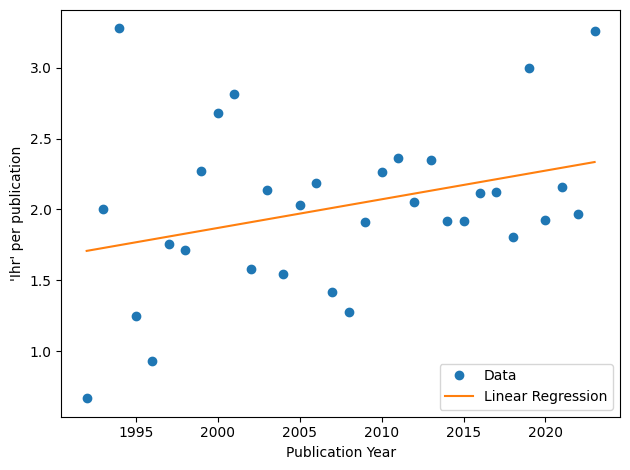

In [27]:
# Visualize the data of 'Ihr' per publication
# Fit a linear regression curve to the data
X = sm.add_constant(df_yearly_overview['publication_year'])
y = df_yearly_overview['ihr_ratio_per_article']
model = sm.OLS(y.astype(float), X.astype(float))
results = model.fit()
print(results.summary())

# Print the confidence intervals for the coefficients
conf_int = results.conf_int()
print("\nConfidence Intervals for the Coefficients:")
print(conf_int)

# Plot the data points and the linear regression curve
plt.plot(df_yearly_overview['publication_year'], y, 'o', label='Data')
plt.plot(df_yearly_overview['publication_year'], results.predict(X), label='Linear Regression')
plt.xlabel('Publication Year')
plt.ylabel('\'Ihr\' per publication')
plt.legend()
plt.savefig('../Visuals/count_ihr_per_publication.png')
plt.show()

                            OLS Regression Results                            
Dep. Variable:     ihr_ratio_per_word   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.212
Date:                Mon, 22 Jan 2024   Prob (F-statistic):              0.280
Time:                        17:41:42   Log-Likelihood:                 183.76
No. Observations:                  32   AIC:                            -363.5
Df Residuals:                      30   BIC:                            -360.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0375      0.031  

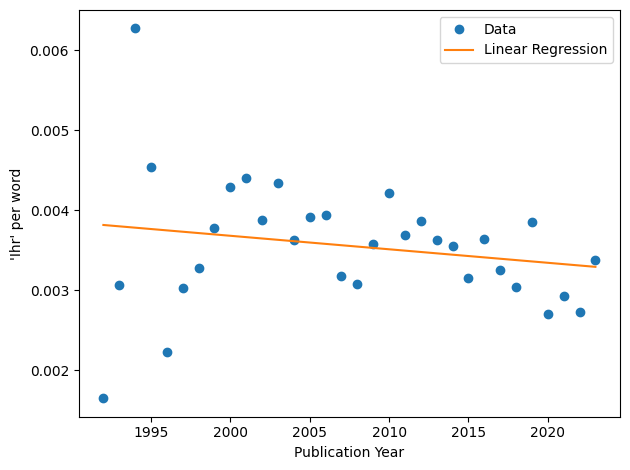

In [28]:
# Visualize the data of 'Ihr' per word
# Fit a linear regression curve to the data
X = sm.add_constant(df_yearly_overview['publication_year'])
y = df_yearly_overview['ihr_ratio_per_word']
model = sm.OLS(y.astype(float), X.astype(float))
results = model.fit()
print(results.summary())

# Print the confidence intervals for the coefficients
conf_int = results.conf_int()
print("\nConfidence Intervals for the Coefficients:")
print(conf_int)

# Plot the data points and the linear regression curve
plt.plot(df_yearly_overview['publication_year'], y, 'o', label='Data')
plt.plot(df_yearly_overview['publication_year'], results.predict(X), label='Linear Regression')
plt.xlabel('Publication Year')
plt.ylabel('\'Ihr\' per word')
plt.legend()
plt.savefig('../Visuals/count_ihr_per_word.png')
plt.show()

                               OLS Regression Results                              
Dep. Variable:     articles_with_ihr_ratio   R-squared:                       0.065
Model:                                 OLS   Adj. R-squared:                  0.033
Method:                      Least Squares   F-statistic:                     2.073
Date:                     Mon, 22 Jan 2024   Prob (F-statistic):              0.160
Time:                             17:41:42   Log-Likelihood:                 43.460
No. Observations:                       32   AIC:                            -82.92
Df Residuals:                           30   BIC:                            -79.99
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

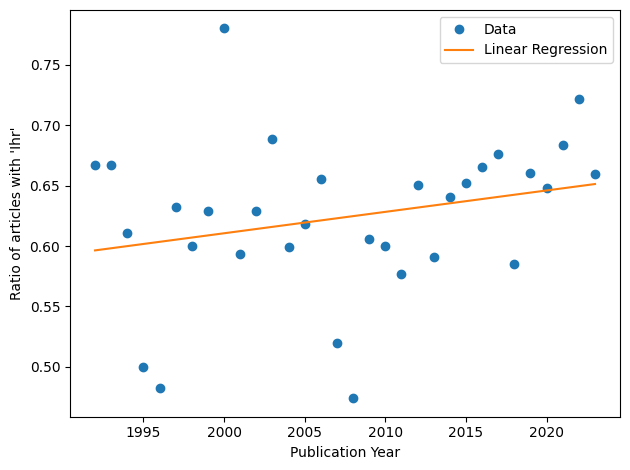

In [29]:
# Visualize the data of articles with 'Ihr' per publication
# Fit a linear regression curve to the data
X = sm.add_constant(df_yearly_overview['publication_year'])
y = df_yearly_overview['articles_with_ihr_ratio']
model = sm.OLS(y.astype(float), X.astype(float))
results = model.fit()
print(results.summary())

# Print the confidence intervals for the coefficients
conf_int = results.conf_int()
print("\nConfidence Intervals for the Coefficients:")
print(conf_int)

# Plot the data points and the linear regression curve
plt.plot(df_yearly_overview['publication_year'], y, 'o', label='Data')
plt.plot(df_yearly_overview['publication_year'], results.predict(X), label='Linear Regression')
plt.xlabel('Publication Year')
plt.ylabel('Ratio of articles with \'Ihr\'')
plt.legend()
plt.savefig('../Visuals/articles_with_ihr_ratrio.png')
plt.show()

### Overview over the usage of 'Du' / 'Ihr'

                               OLS Regression Results                               
Dep. Variable:     du_ihr_ratio_per_article   R-squared:                       0.126
Model:                                  OLS   Adj. R-squared:                  0.097
Method:                       Least Squares   F-statistic:                     4.331
Date:                      Mon, 22 Jan 2024   Prob (F-statistic):             0.0461
Time:                              17:41:43   Log-Likelihood:                -26.643
No. Observations:                        32   AIC:                             57.29
Df Residuals:                            30   BIC:                             60.22
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

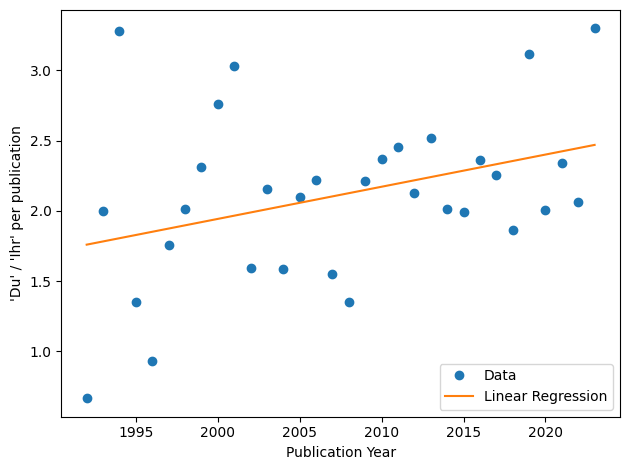

In [30]:
# Visualize the data of 'Du' and 'Ihr' per publication
# Fit a linear regression curve to the data
X = sm.add_constant(df_yearly_overview['publication_year'])
y = df_yearly_overview['du_ihr_ratio_per_article']
model = sm.OLS(y.astype(float), X.astype(float))
results = model.fit()
print(results.summary())

# Print the confidence intervals for the coefficients
conf_int = results.conf_int()
print("\nConfidence Intervals for the Coefficients:")
print(conf_int)

# Plot the data points and the linear regression curve
plt.plot(df_yearly_overview['publication_year'], y, 'o', label='Data')
plt.plot(df_yearly_overview['publication_year'], results.predict(X), label='Linear Regression')
plt.xlabel('Publication Year')
plt.ylabel('\'Du\' / \'Ihr\' per publication')
plt.legend()
plt.savefig('../Visuals/count_du_ihr_per_publication.png')
plt.show()

                              OLS Regression Results                             
Dep. Variable:     du_ihr_ratio_per_word   R-squared:                       0.027
Model:                               OLS   Adj. R-squared:                 -0.006
Method:                    Least Squares   F-statistic:                    0.8237
Date:                   Mon, 22 Jan 2024   Prob (F-statistic):              0.371
Time:                           17:41:43   Log-Likelihood:                 182.54
No. Observations:                     32   AIC:                            -361.1
Df Residuals:                         30   BIC:                            -358.1
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const     

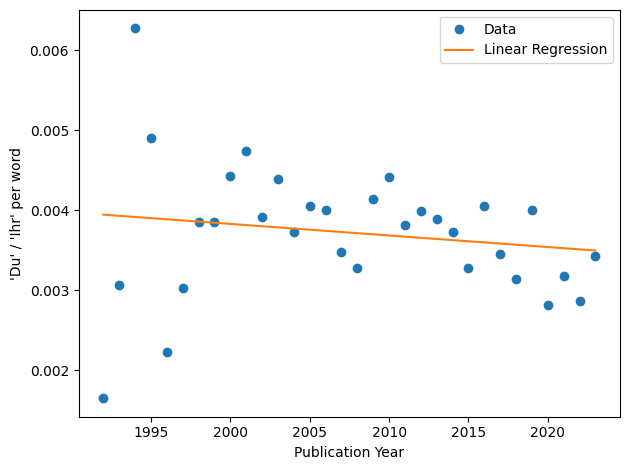

In [31]:
# Visualize the data of 'Du' and 'Ihr' per word
# Fit a linear regression curve to the data
X = sm.add_constant(df_yearly_overview['publication_year'])
y = df_yearly_overview['du_ihr_ratio_per_word']
model = sm.OLS(y.astype(float), X.astype(float))
results = model.fit()
print(results.summary())

# Print the confidence intervals for the coefficients
conf_int = results.conf_int()
print("\nConfidence Intervals for the Coefficients:")
print(conf_int)

# Plot the data points and the linear regression curve
plt.plot(df_yearly_overview['publication_year'], y, 'o', label='Data')
plt.plot(df_yearly_overview['publication_year'], results.predict(X), label='Linear Regression')
plt.xlabel('Publication Year')
plt.ylabel('\'Du\' / \'Ihr\' per word')
plt.legend()
plt.savefig('../Visuals/count_du_ihr_per_word.png')
plt.show()

                                OLS Regression Results                                
Dep. Variable:     articles_with_du_ihr_ratio   R-squared:                       0.082
Model:                                    OLS   Adj. R-squared:                  0.051
Method:                         Least Squares   F-statistic:                     2.666
Date:                        Mon, 22 Jan 2024   Prob (F-statistic):              0.113
Time:                                17:41:43   Log-Likelihood:                 45.069
No. Observations:                          32   AIC:                            -86.14
Df Residuals:                              30   BIC:                            -83.21
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

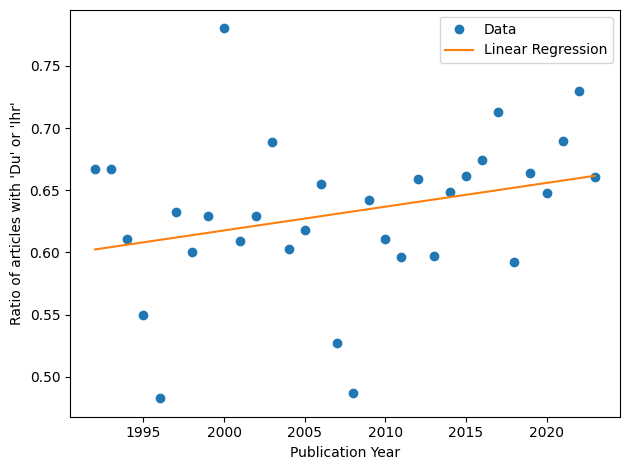

In [32]:
# Visualize the data of articles with 'Du' and 'Ihr' per publication
# Fit a linear regression curve to the data
X = sm.add_constant(df_yearly_overview['publication_year'])
y = df_yearly_overview['articles_with_du_ihr_ratio']
model = sm.OLS(y.astype(float), X.astype(float))
results = model.fit()
print(results.summary())

# Print the confidence intervals for the coefficients
conf_int = results.conf_int()
print("\nConfidence Intervals for the Coefficients:")
print(conf_int)

# Plot the data points and the linear regression curve
plt.plot(df_yearly_overview['publication_year'], y, 'o', label='Data')
plt.plot(df_yearly_overview['publication_year'], results.predict(X), label='Linear Regression')
plt.xlabel('Publication Year')
plt.ylabel('Ratio of articles with \'Du\' or \'Ihr\'')
plt.legend()
plt.savefig('../Visuals/articles_with_du_ihr_ratrio.png')
plt.show()